In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# Define a function to load an image and limit its maximum dimension to 512 pixels
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

90112/83281 [================================] - 0s 0us/step


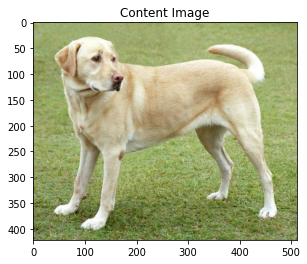

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_img(content_path)
imshow(content_image, 'Content Image')

In [ ]:
# Creates a vgg model that returns a list of intermediate output values
def create_new_model(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# create the model:
content_layers = ['block3_conv1', 'block4_conv1', 'block5_conv1']
new_model = create_new_model(content_layers)
content_outputs = new_model(content_image*255)
print(type(content_outputs))
print(content_outputs[0].shape)

# Look at the statistics of each layer's output
for name, output in zip(content_layers, content_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

<class 'list'>
(1, 105, 128, 256)
block3_conv1
  shape:  (1, 105, 128, 256)
  min:  0.0
  max:  6522.3745
  mean:  126.78171

block4_conv1
  shape:  (1, 52, 64, 512)
  min:  0.0
  max:  14053.979
  mean:  526.2268

block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  3854.7976
  mean:  42.088894



In [ ]:
class ContentModel(tf.keras.models.Model):
  def __init__(self, content_layers):
    super(ContentModel, self).__init__()
    self.new_model = create_new_model(content_layers)
    self.content_layers = content_layers
    self.new_model.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    content_outputs = self.new_model(preprocessed_input)

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    return content_dict

In [ ]:
extractor = ContentModel(content_layers)
content_targets = extractor(content_image)

(1, 422, 512, 3)


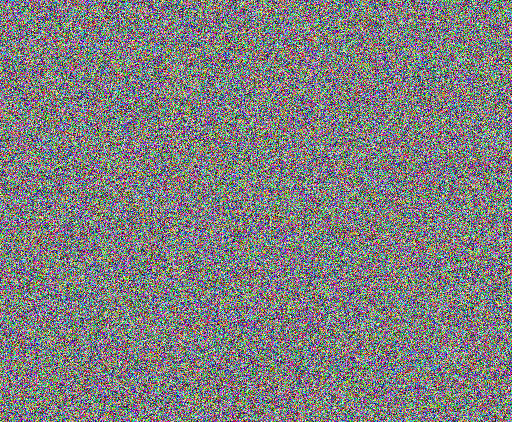

In [ ]:
image = tf.Variable(tf.random.uniform(content_image.shape, minval=0, maxval=1))
print(image.shape)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))
fname = '/content/gdrive/My Drive/data/style_transfer/content_loss_3L/at_%d.png' % 0
mpl.image.imsave(fname, image[0].numpy())

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
def content_loss(content_outputs):
    loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = content_loss(outputs)*1e4

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

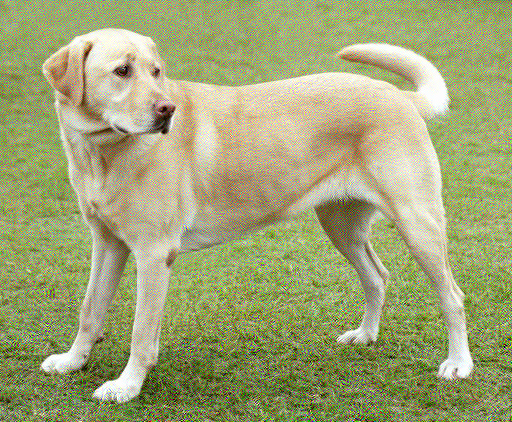

Train step: 6000
Total time: 1444.5


In [ ]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 200

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

  fname = '/content/gdrive/My Drive/data/style_transfer/content_loss_3L/at_%d.png' % (n+1)
  mpl.image.imsave(fname, image[0].numpy())
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)